In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score
import numpy as np

In [ ]:
# Paths
train_path = "/content/fire_dataset/train"
val_path = "/content/fire_dataset/val"
test_path = "/content/fire_dataset/test"

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
# CNN Model
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [ ]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Datasets and Dataloaders
train_dataset = ImageFolder(root=train_path, transform=transform)
val_dataset = ImageFolder(root=val_path, transform=transform)
test_dataset = ImageFolder(root=test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# Model
model = CNNModel(num_classes=len(train_dataset.classes)).to(device)

# Optimizer, Loss Function, and Scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40, 80], gamma=0.3)
criterion = nn.CrossEntropyLoss()

# Training and Validation Function
def train_and_validate(model, train_loader, val_loader, epochs):
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        scheduler.step()

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss / len(train_loader):.4f}, "
              f"Validation Loss: {val_loss / len(val_loader):.4f}, Accuracy: {accuracy:.2f}%")

    # Model weights save
    torch.save(model.state_dict(), "cnn_model.pth")
    print("Model ağırlıkları cnn_model.pth dosyasına kaydedildi.")

In [ ]:
# Training the model
epochs = 100
train_and_validate(model, train_loader, val_loader, epochs)

# Loading the model weights
model.load_state_dict(torch.load("cnn_model.pth"))
model.to(device)
print("Model ağırlıkları cnn_model.pth dosyasından yüklendi.")

Epoch [1/100], Train Loss: 0.3219, Validation Loss: 0.3174, Accuracy: 89.39%
Epoch [2/100], Train Loss: 0.3515, Validation Loss: 0.2794, Accuracy: 91.02%
Epoch [3/100], Train Loss: 0.2988, Validation Loss: 0.3036, Accuracy: 88.57%
Epoch [4/100], Train Loss: 0.2222, Validation Loss: 0.2404, Accuracy: 93.06%
Epoch [5/100], Train Loss: 0.2310, Validation Loss: 0.3474, Accuracy: 89.80%
Epoch [6/100], Train Loss: 0.1607, Validation Loss: 0.3032, Accuracy: 91.02%
Epoch [7/100], Train Loss: 0.1692, Validation Loss: 0.7138, Accuracy: 79.59%
Epoch [8/100], Train Loss: 0.2041, Validation Loss: 0.3215, Accuracy: 91.84%
Epoch [9/100], Train Loss: 0.1284, Validation Loss: 0.2507, Accuracy: 90.20%
Epoch [10/100], Train Loss: 0.1247, Validation Loss: 0.4039, Accuracy: 93.88%
Epoch [11/100], Train Loss: 0.1304, Validation Loss: 0.3093, Accuracy: 93.06%
Epoch [12/100], Train Loss: 0.0823, Validation Loss: 0.3938, Accuracy: 93.06%
Epoch [13/100], Train Loss: 0.0580, Validation Loss: 0.3225, Accuracy: 93

<ipython-input-36-a195ce31cd6c>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cnn_model.pth"))


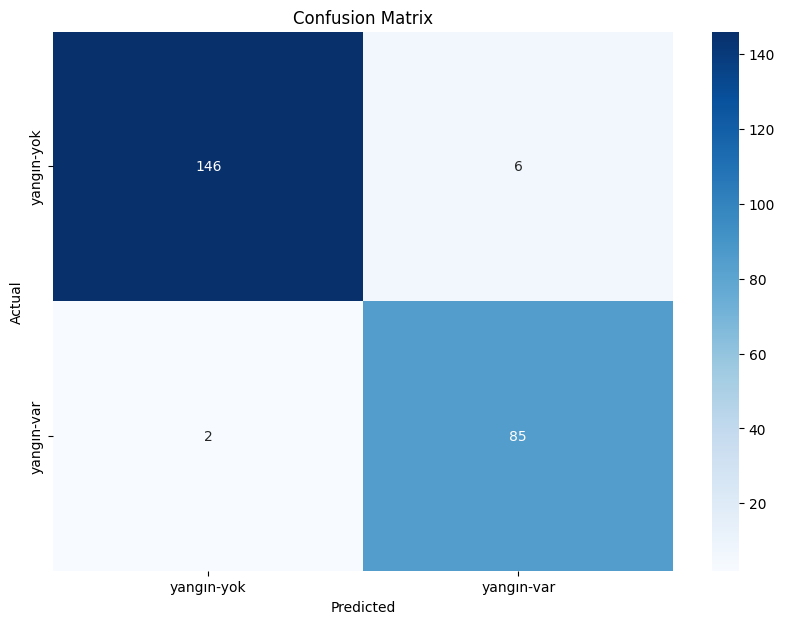

Precision: 0.934
Recall: 0.9770
Specificity: 0.961
FP Rate: 0.039

Accuracy: 96.65%
Miss Rate: 0.02
F1 Score: 0.967
AUC Score: 0.993


<ipython-input-63-9795cf5e8a2f>:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')


<Figure size 640x480 with 0 Axes>

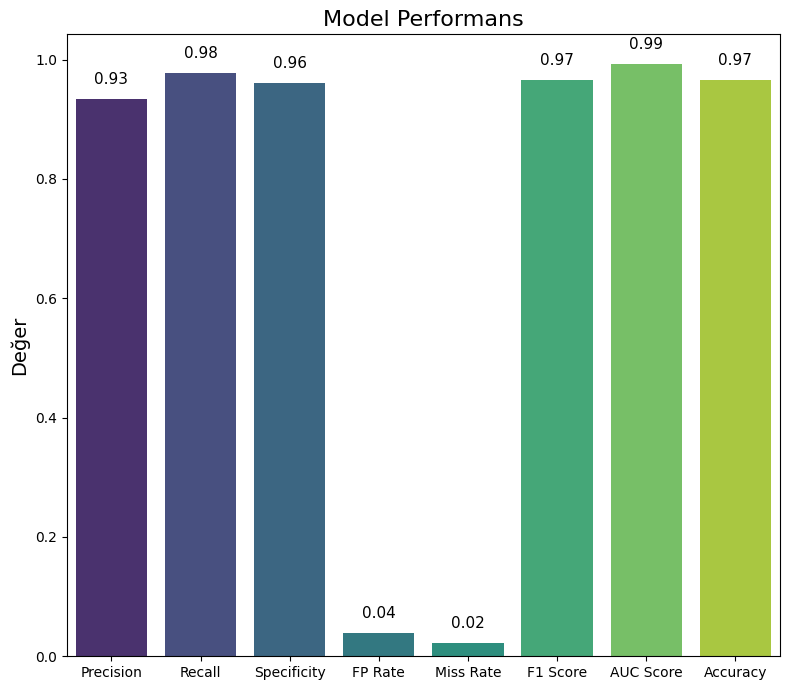

<Figure size 640x480 with 0 Axes>

In [ ]:
# Test Function with Enhanced Visualization
def test_model_with_visualization(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []  # Softmax scores
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            # Get the probability for the positive class (assuming class 1 is positive)
            scores = torch.softmax(outputs, dim=1)[:, 1]  # Extract probabilities for class 1
            y_scores.extend(scores.cpu().numpy())
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    fpRate = FP / (FP + TN)

    acc = accuracy_score(y_true, y_pred)
    missRate = FN / (TP + FN)
    f1 = f1_score(y_true, y_pred, average='weighted')
    auc = roc_auc_score(y_true, np.array(y_scores), multi_class="ovr")

    # Confusion Matrix Visualization
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["yangın-yok", "yangın-var"], yticklabels=["yangın-yok", "yangın-var"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    plt.tight_layout()
    plt.savefig('/content/confusion_matrix.png', format='png')

    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.4f}")
    print(f"Specificity: {specificity:.3f}")
    print(f"FP Rate: {fpRate:.3f}")
    print(f"\nAccuracy: {acc * 100:.2f}%")
    print(f"Miss Rate: {missRate:.2f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"AUC Score: {auc:.3f}")

    # Metrikleri bir listeye koyabiliriz
    metrics = {
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'FP Rate': fpRate,
        'Miss Rate': missRate,
        'F1 Score': f1,
        'AUC Score': auc,
        'Accuracy': acc
    }

    # Görselleştirme
    fig, ax = plt.subplots(figsize=(8, 7))

    # Performans metriklerini çubuk grafikte gösterelim
    sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')

    # Başlık ve etiketler
    ax.set_title('Model Performans', fontsize=16)
    ax.set_ylabel('Değer', fontsize=14)

    # Değerleri üstüne ekleyelim
    for i, v in enumerate(metrics.values()):
        ax.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=11)

    # Grafiği göster
    plt.tight_layout()
    plt.show()
    plt.tight_layout()
    plt.savefig('/content/performance_metrics.png', format='png')

# Model Evaluation with Visualization
test_model_with_visualization(model, test_loader)
